# Mangroves 
## 3.0.0 vs 4.0.0

Check list: 

    [x] compare the two versions in Maps/Terria
    [x] compare the two versions in Explorer
    [x] plot random tiles, check impact of cloud and shadow buffering on no data values. Years 1990, 2010, 2015, 2022.
     

In [1]:
import datacube
import pandas as pd
import sys
import rioxarray as rioxr
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

dc = datacube.Datacube(app="")

In [2]:
# functions to use

def load_mangroves_3(tile, year):
    """
    load mangroves v3 over tile extent.
    """
    mangroves_3 = dc.load(
                product="ga_ls_mangrove_cover_cyear_3",
                region_code = tile, 
                time=year,
    )
    return mangroves_3

def load_mangroves_4(tile, year):
    """
    load mangroves v4 tiles from s3.
    """
    base_url = "s3://dea-public-data/derivative/ga_ls_mangrove_cover_cyear_3/4-0-0/{}/{}/{}--P1Y/ga_ls_mangrove_cover_cyear_3_{}_{}--P1Y_final_canopy_cover_class.tif"
    x_val = tile[:3]
    y_val = tile[-3:]
    url = base_url.format(x_val, y_val, year, tile, year)
    mangroves_3 = rioxr.open_rasterio(url)
    return mangroves_3

tile_lookup = pd.read_csv('grid_lookup.csv', sep=',', na_values=['NA'])
def lookup_old_value(new_value):
    """
    returns old region code because version 3 mangroves uses the old grid
    """
    result = tile_lookup[tile_lookup['new'] == new_value]
    result = result['old'].values[0]
    return result

def count_pixels(data):
    """
    returns count of unique pixels
    """
    unique_values, counts = np.unique(data, return_counts=True)
    unique_counts = dict(zip(unique_values, counts))
    return unique_counts

def print_pixel_info(tile, year):
    """
    Print pixel counts and percentage change between versions.
    """
    tile_old = lookup_old_value(tile)
    v3 = load_mangroves_3(tile_old, year)
    v4 = load_mangroves_4(tile, year)
    print('---------------------------------------------------------------------------------')
    print(f'{tile}')
    print('0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data')
    print('---------------------------------------------------------------------------------')
    print('Pixel count version 3')
    print('---------------------------------------------------------------------------------')
    count_pixels_3 = count_pixels(v3.canopy_cover_class)
    for value, count in count_pixels_3.items():
        print(f'Value: {value:,}, Count: {count:,}')
    print('---------------------------------------------------------------------------------')
    print('Pixel count version 4')
    print('---------------------------------------------------------------------------------')
    count_pixels_4 = count_pixels(v4.values)
    for value, count in count_pixels_4.items():
        print(f'Value: {value:,}, Count: {count:,}')
    print('---------------------------------------------------------------------------------')
    print('Percentage change from version 3 to version 4')
    print('---------------------------------------------------------------------------------')
    for value in set(count_pixels_3.keys()).union(count_pixels_4.keys()):
        count_v3 = count_pixels_3.get(value, 0)
        count_v4 = count_pixels_4.get(value, 0)
        if count_v3 != 0:  # To avoid division by zero
            percent_change = ((count_v4 - count_v3) / count_v3) * 100
            print(f'Value: {value}, Percentage Change: {percent_change:.2f}%')
        else:
            print(f'Value: {value}, Percentage Change: Undefined (divided by zero)')
    sys.stdout.flush()
    
    
def plot_tile(tile, year):
    """
    Plot version 3 and 4 mangroves products next to each other.
    """
    tile_old = lookup_old_value(tile)
    v3 = load_mangroves_3(tile_old, year)
    v4 = load_mangroves_4(tile, year)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    img1 = ax1.imshow(v3.canopy_cover_class.squeeze(), cmap='Greens_r')
    img2 = ax2.imshow(v4.squeeze(), cmap='Greens_r')
    ax1.set_title(f'{tile_old} mangroves v3')
    ax2.set_title(f'{tile} mangroves v4')
    fig.colorbar(img1, ax=ax1)
    fig.colorbar(img2, ax=ax2)
    
    plt.show()
    plt.close()

def plot_tile_and_info(tile, year):
    """
    Print pixel info and plot mangroves products for a given tile and year.
    """
    print_pixel_info(tile, year)
    plot_tile(tile, year)
  

---------------------------------------------------------------------------------
x27y45
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 17
Value: 1, Count: 54,432
Value: 2, Count: 46,339
Value: 3, Count: 6,140
Value: 255, Count: 10,133,072
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 27
Value: 1.0, Count: 46,699
Value: 2.0, Count: 54,561
Value: 3.0, Count: 5,263
Value: 255.0, Count: 10,133,450
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
-----------------------------------------------------------------------------

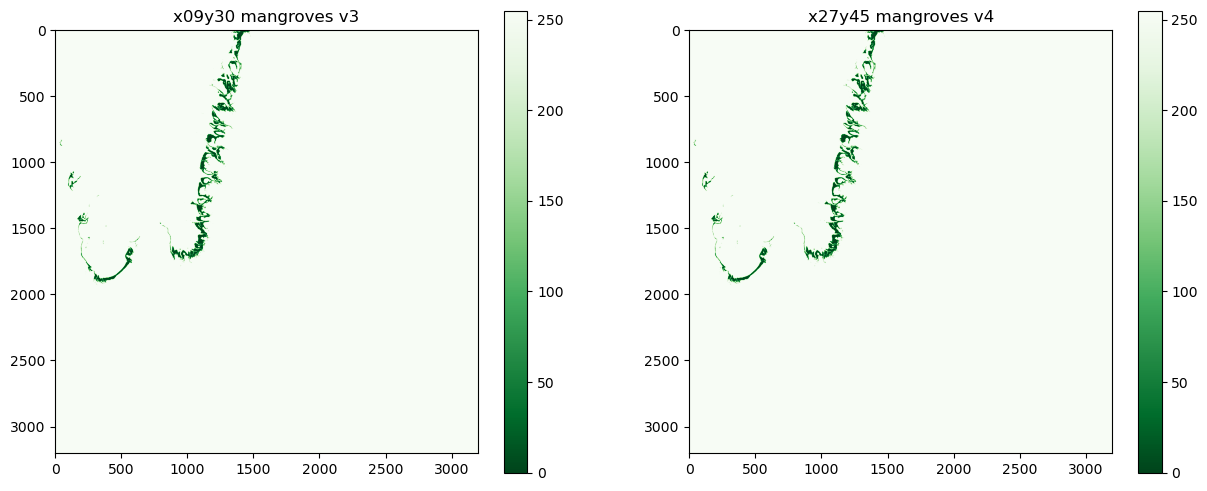

---------------------------------------------------------------------------------
x37y53
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 7
Value: 1, Count: 46,710
Value: 2, Count: 117,801
Value: 3, Count: 125,925
Value: 255, Count: 9,949,557
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 10
Value: 1.0, Count: 49,401
Value: 2.0, Count: 115,204
Value: 3.0, Count: 125,594
Value: 255.0, Count: 9,949,791
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
--------------------------------------------------------------------------

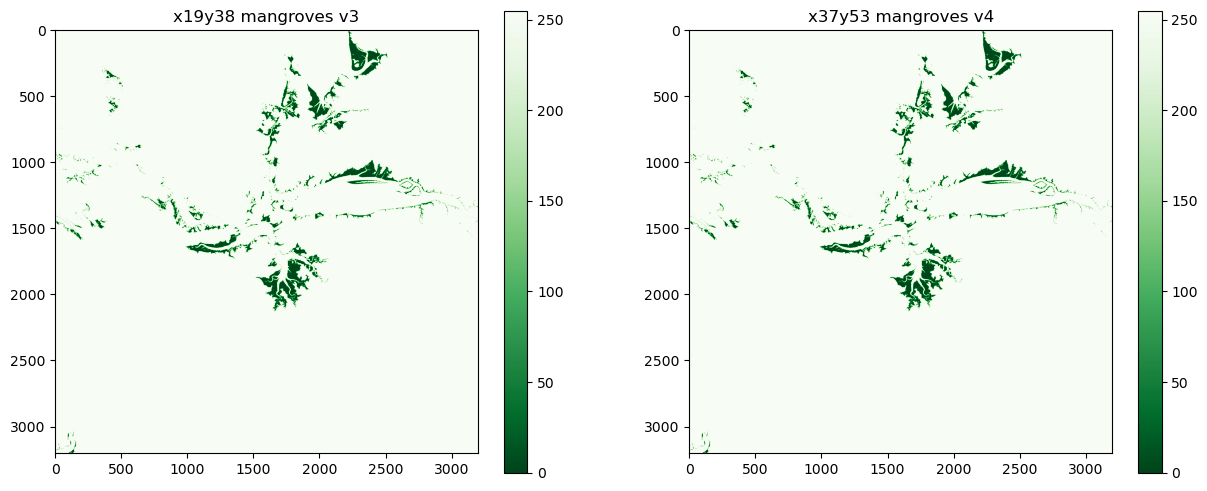

---------------------------------------------------------------------------------
x44y58
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 86
Value: 1, Count: 38,830
Value: 2, Count: 180,594
Value: 3, Count: 275,369
Value: 255, Count: 9,745,121
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 193
Value: 1.0, Count: 39,531
Value: 2.0, Count: 151,001
Value: 3.0, Count: 299,810
Value: 255.0, Count: 9,749,465
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
------------------------------------------------------------------------

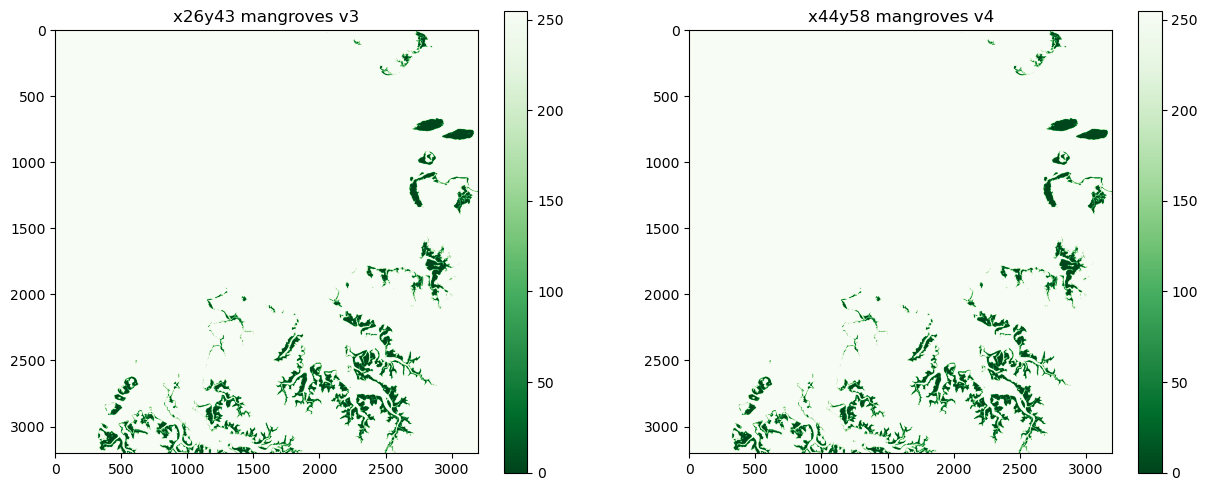

---------------------------------------------------------------------------------
x50y58
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 40
Value: 1, Count: 57,126
Value: 2, Count: 166,006
Value: 3, Count: 108,733
Value: 255, Count: 9,908,095
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 124
Value: 1.0, Count: 54,186
Value: 2.0, Count: 143,971
Value: 3.0, Count: 131,257
Value: 255.0, Count: 9,910,462
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
------------------------------------------------------------------------

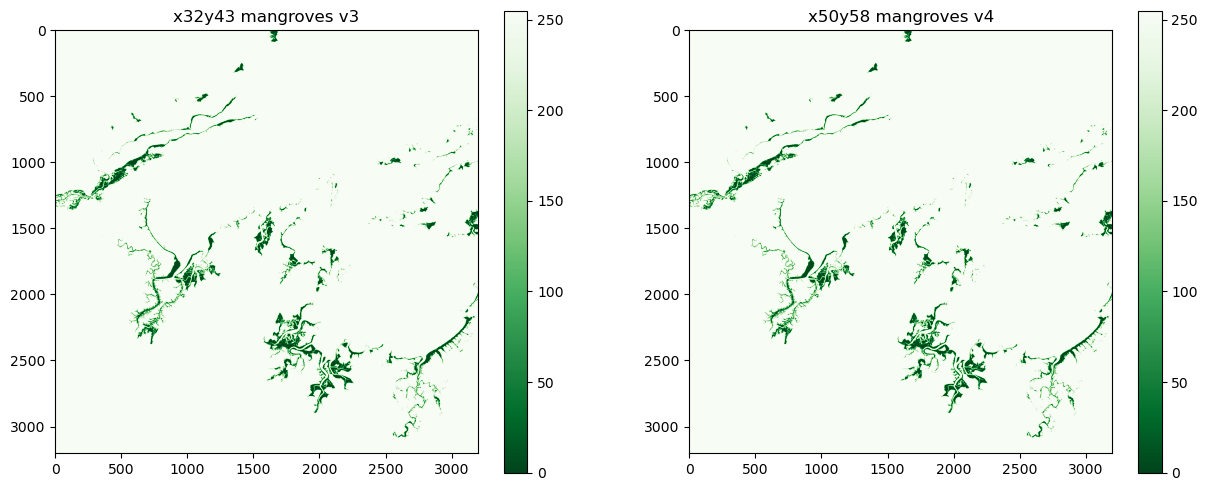

---------------------------------------------------------------------------------
x57y58
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 59
Value: 1, Count: 17,420
Value: 2, Count: 142,669
Value: 3, Count: 164,651
Value: 255, Count: 9,915,201
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 163
Value: 1.0, Count: 13,579
Value: 2.0, Count: 103,057
Value: 3.0, Count: 204,985
Value: 255.0, Count: 9,918,216
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
------------------------------------------------------------------------

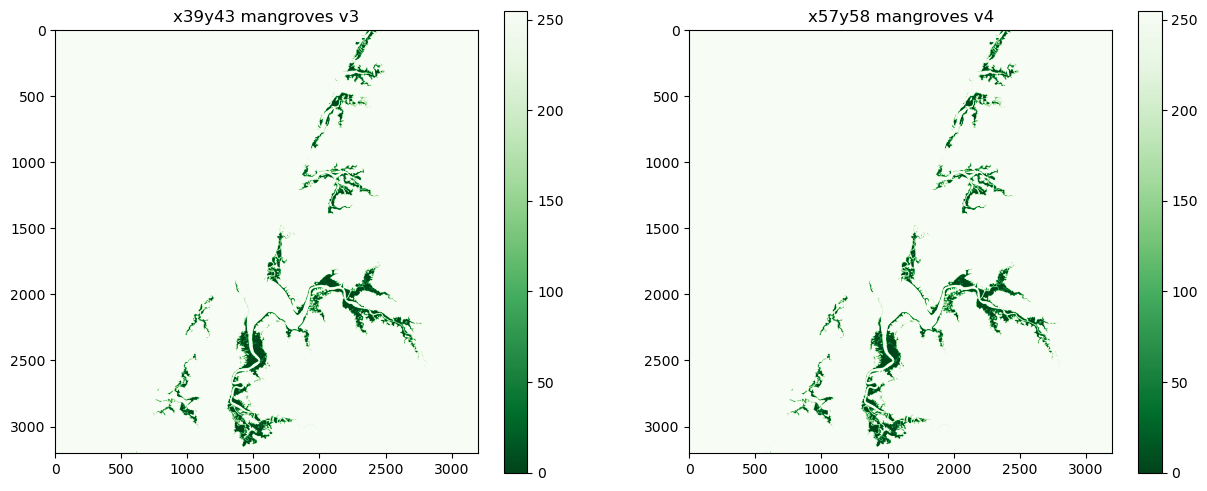

---------------------------------------------------------------------------------
x67y38
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 43
Value: 1, Count: 15,046
Value: 2, Count: 38,552
Value: 3, Count: 35,298
Value: 255, Count: 10,151,061
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 62
Value: 1.0, Count: 11,619
Value: 2.0, Count: 36,172
Value: 3.0, Count: 40,608
Value: 255.0, Count: 10,151,539
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
---------------------------------------------------------------------------

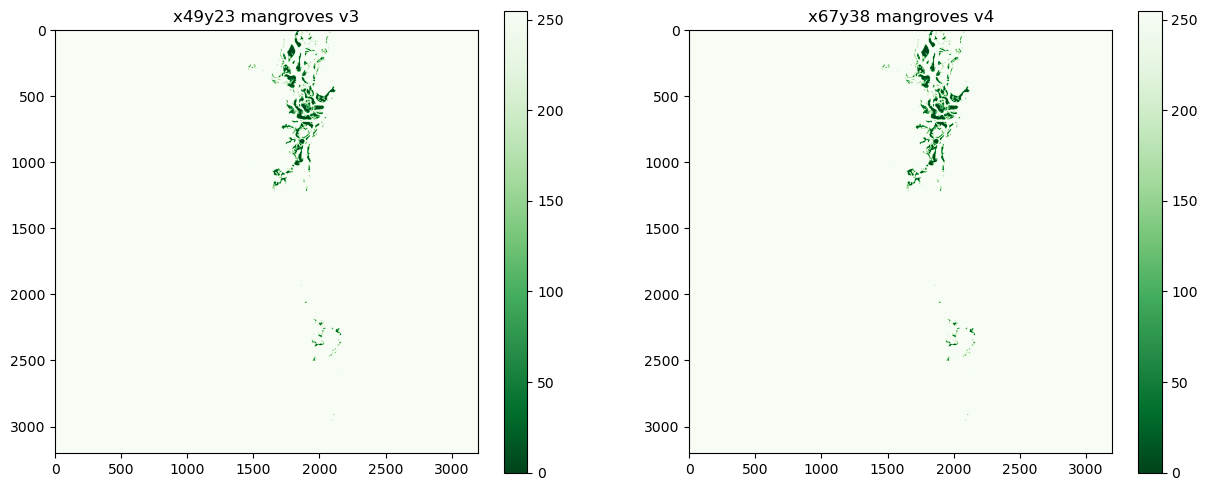

---------------------------------------------------------------------------------
x65y33
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 13
Value: 1, Count: 10,397
Value: 2, Count: 32,974
Value: 3, Count: 10,080
Value: 255, Count: 10,186,536
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 41
Value: 1.0, Count: 9,940
Value: 2.0, Count: 29,134
Value: 3.0, Count: 13,733
Value: 255.0, Count: 10,187,152
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
----------------------------------------------------------------------------

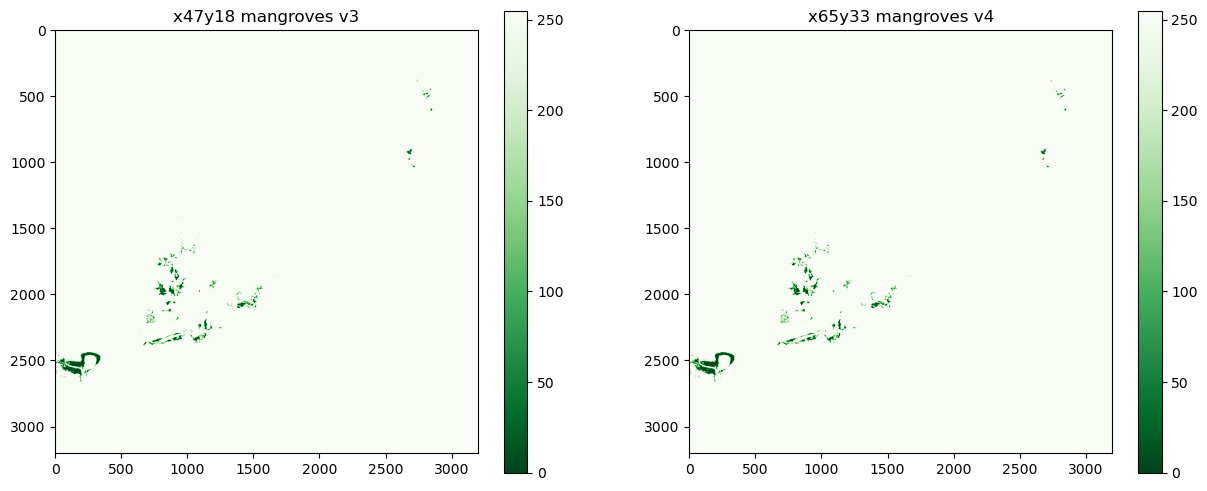

---------------------------------------------------------------------------------
x59y27
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 39
Value: 1, Count: 9,407
Value: 2, Count: 5,573
Value: 3, Count: 1,037
Value: 255, Count: 10,223,944
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 64
Value: 1.0, Count: 6,386
Value: 2.0, Count: 6,026
Value: 3.0, Count: 1,634
Value: 255.0, Count: 10,225,890
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
---------------------------------------------------------------------------------

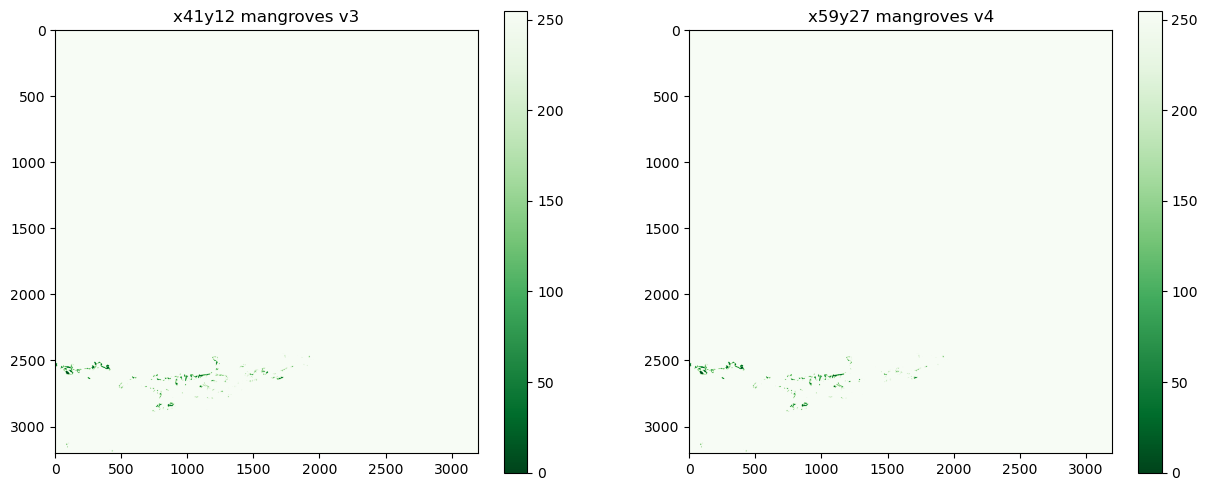

---------------------------------------------------------------------------------
x51y34
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 0, Count: 2
Value: 1, Count: 43,909
Value: 2, Count: 27,198
Value: 3, Count: 20,543
Value: 255, Count: 10,148,348
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 14
Value: 1.0, Count: 40,068
Value: 2.0, Count: 29,642
Value: 3.0, Count: 21,344
Value: 255.0, Count: 10,148,932
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
----------------------------------------------------------------------------

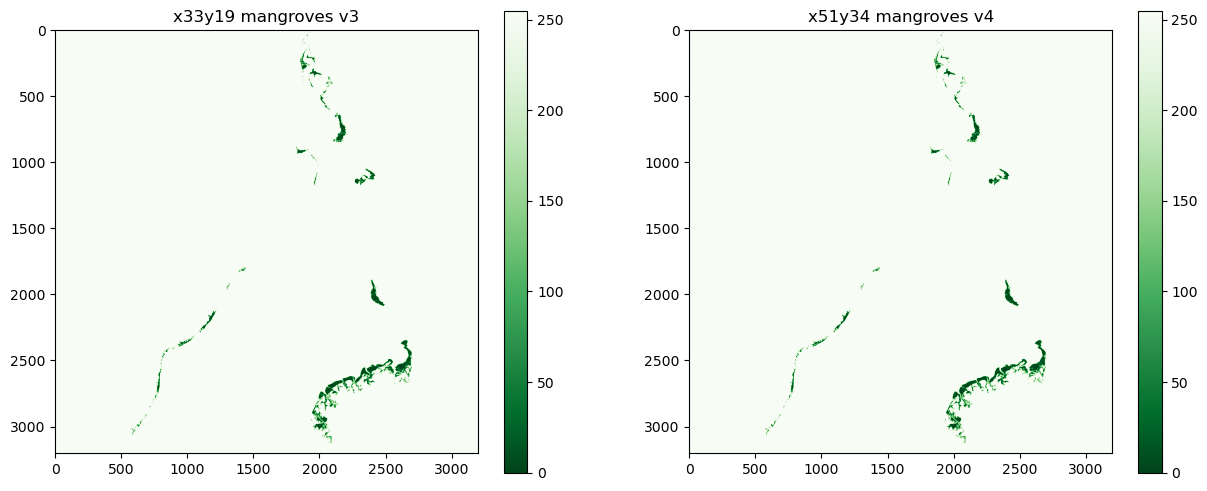

In [3]:
tile_list = ['x27y45', 'x37y53', 'x44y58', 'x50y58', 'x57y58', 'x67y38', 'x65y33', 'x59y27', 'x51y34']

for tile in tile_list:
    plot_tile_and_info(tile, '1990')

In [ ]:
tile_list = ['x27y45', 'x37y53', 'x44y58', 'x50y58', 'x57y58', 'x67y38', 'x65y33', 'x59y27', 'x51y34']

for tile in tile_list:
    plot_tile_and_info(tile, '2010')

---------------------------------------------------------------------------------
x27y45
0 = not observed, 1 = woodland, 2 = open forest, 3 = closed forest, 225 = no data
---------------------------------------------------------------------------------
Pixel count version 3
---------------------------------------------------------------------------------
Value: 1, Count: 39,826
Value: 2, Count: 56,942
Value: 3, Count: 4,246
Value: 255, Count: 10,138,986
---------------------------------------------------------------------------------
Pixel count version 4
---------------------------------------------------------------------------------
Value: 0.0, Count: 10
Value: 1.0, Count: 42,568
Value: 2.0, Count: 54,159
Value: 3.0, Count: 3,803
Value: 255.0, Count: 10,139,460
---------------------------------------------------------------------------------
Percentage change from version 3 to version 4
---------------------------------------------------------------------------------
Value: 0.0, Per

In [ ]:
tile_list = ['x27y45', 'x37y53', 'x44y58', 'x50y58', 'x57y58', 'x67y38', 'x65y33', 'x59y27', 'x51y34']

for tile in tile_list:
    plot_tile_and_info(tile, '2015')

In [ ]:
tile_list = ['x27y45', 'x37y53', 'x44y58', 'x50y58', 'x57y58', 'x67y38', 'x65y33', 'x59y27', 'x51y34']

for tile in tile_list:
    plot_tile_and_info(tile, '2022')